# Exercise set 7: Spatial data

In this exercise set you will be working with structuring and plotting spatial data. 
- Exercise 7.1: Basic shapes
- Exercise 7.2: Working with Geopandas and interpolation
- Exercise 7.3: Interactive plotting with folium

We begin with loading the standard packages:


In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely

%matplotlib inline

## Part 7.1: Working with spatial objects 

This exercise will serve as a brief tutorial on spatial data. We will learn how to make spatial shape and use their basic operations.

> **Ex. 7.1.1** Make a polygon which is square that has left, lower corner in 2,2 and right, upper in 5,5. Make a triangle passing through (0,0), (4,0) and (2,4). What do they look like? Store the two polygons respectively as `square` and `triangle`

> *Hint*: the submodule shapely.geometry has methods such as `Point`, `Polygon` and `MultiPolygon`

In [2]:
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

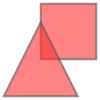

In [3]:
# [Your answer here]
square = Polygon(np.array([[2,2],[5,2],[5,5],[2,5]])) #([[lower left], [lower right], [upper right], [upper left]])
triangle = Polygon(np.array([[0,0], [4,0], [2,4]]))
MultiPolygon([square, triangle])

> **Ex. 7.1.2** Compute and show the spatial difference of square subtracted triangle, also show the hat is the union of `square` and `triangle`?

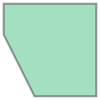

In [4]:
# [Your answer here]
diff = square - triangle
diff

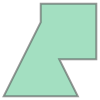

In [5]:
union = square | triangle
union

> **Ex. 7.1.3** Make a GeoSeries out of `square`, `triangle`. Plot the geoseries.

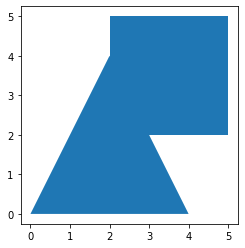

In [6]:
# [Your answer here]
geo = gpd.GeoSeries([square, triangle])
geo.plot()

## Part 7.2: Working with house sale prices

Data on danish municipalities are available [here](https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson) from Open Knowledge Denmark.

#### Basic operations with Geopandas

> **Ex. 7.2.1** Load the municipalities data using `gpd.read_file()`, 
- What is the CRS of the dataframe - what projection does it correspond to? Turn the CRS into a meter based system.
- Which three munipalities have the largest area?

> Note: to find the entire area of a municipality which consists of multiple shapes (e.g. municipalities covering islands), you can use the `unary_union` method for GeoSeries.

**Notes**:

CRS: Coordinate reference system

In lecture 7, we're introduced to two different types of CRS: (*i*) The Geographic Coordinate System (GCS), which the Global Positioning System (GPS) is an example of, where coordinates are referenced in decimal degrees, and (*ii*) the Projected Coordinate System (PCS), which the Danish mapping reference (ETRS89 UTM Zone 32 North) is an example of, where coordinates are referenced in linear units, e.g. metres. Both CRS's are 2-dimensional and has orientation North and East. 


**Answer**:

- From looking at the data, I would guess that the CRS of the DataFrame is GCS, since the first coordinate is around 8-12 and the second is around 54-57, which is Denmark's coordinates in degrees. Just realised the attribute `.crs`! My GeoDataFrame is measured in the EPSG: 4326, which is the Global Positioning System. 

- The three largest municipalities are: 

| Municipality | Area in sq. km |
| --- | --- |
| Ringkøbing-Skjern | 1494 |
| Viborg | 1420 |
| Herning | 1323 |

In [7]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"

In [8]:
# [Your answer here]

# Loading data
kommuner = gpd.read_file(url)

# Get CRS of the GeoDataFrame
print(kommuner.crs)

# Rename variables
columns_dict = {}
columns_dict['KOMNAVN'] = 'municipality'
columns_dict['KOMKODE'] = 'code'

kommuner.rename(columns = columns_dict, inplace = True)

# Show first 5 observations
print(kommuner.head())

# Convert to metres
kommuner = kommuner.to_crs({'init':'epsg:25832'}) # Converting to the Danish coordinate reference

# Show first 5 observations
kommuner.head()

{'init': 'epsg:4326'}
   code municipality                                           geometry
0  0766    Hedensted  POLYGON Z ((9.44919 55.86046 -999.00000, 9.460...
1  0766    Hedensted  POLYGON Z ((10.06198 55.83301 -999.00000, 10.0...
2  0561      Esbjerg  POLYGON Z ((8.59656 55.53506 -999.00000, 8.601...
3  0849   Jammerbugt  POLYGON Z ((9.78314 57.07319 -999.00000, 9.781...
4  0849   Jammerbugt  POLYGON Z ((9.19738 57.13868 -999.00000, 9.207...


,code,municipality,geometry
0,0766,Hedensted,"POLYGON Z ((528116.000 6190641.000 -999.000, 5..."
1,0766,Hedensted,"POLYGON Z ((566517.000 6188004.430 -999.000, 5..."
2,0561,Esbjerg,"POLYGON Z ((474537.000 6154409.000 -999.000, 4..."
3,0849,Jammerbugt,"POLYGON Z ((547480.000 6325805.000 -999.000, 5..."
4,0849,Jammerbugt,"POLYGON Z ((511946.000 6332841.000 -999.000, 5..."


In [9]:
# Get area of municipalities in square kilometres
kommuner = kommuner[['municipality', 'geometry']]
mun = kommuner.dissolve(by='municipality')
mun["area"] = mun['geometry'].area/10**6 # Now, some of the municipalities are multipolygons and some are just polygons 

# The three largest municipalities
mun.nlargest(3, columns='area')

,geometry,area
municipality,,
Ringkøbing-Skjern,MULTIPOLYGON Z (((455769.510 6207201.150 -999....,1494.150766
Viborg,"POLYGON Z ((518116.060 6272161.120 -999.000, 5...",1419.631354
Herning,"POLYGON Z ((488502.000 6241863.000 -999.000, 4...",1323.127064


<br>
<br>

Use the script below to add regional information for municipalities. This code block assumes that your geodataframe is names `kommuner`.

In [10]:
# Reloading data to get the code below to work 
kommuner = gpd.read_file(url)

# Convert to metres
kommuner = kommuner.to_crs({'init':'epsg:25832'})

In [11]:
kommuner.columns = kommuner.columns.str.lower()
    
# information for municipality
kommune_info = pd.read_json('https://dawa.aws.dk/kommuner')\
                .pipe(lambda df: \
                        df.assign(komkode=df.kode.astype(str).str.zfill(4)))\
                .loc[:,['komkode','regionskode']]\
                

region_info = pd.read_json('https://dawa.aws.dk/regioner/')\
                .loc[:,['kode','navn']]\
                .add_prefix('regions')

kommuner = kommuner\
                .merge(kommune_info,how='left')\
                .merge(region_info,how='left')

> **Ex. 7.2.2** Make two boolean series as follows. 
> - First: Row is `True` if corresponding the row shape is in the Capital Region or Sealand Region (i.e. `'Region Hovedstaden', 'Region Sjælland'`) 
> - Second: Row is `True` if the row geometry is ***not*** in Bornholm or nearby (i.e. `'Bornholm', 'Christiansø'`)

> Finally make a combined series which takes the value True if both holds, otherwise False and use this series to create a new geodataframe containing only mainland Sealand. 


> *Hint*: recall that we can check if a series elements are elements in a series using the `isin` method


In [23]:
# [Your answer here]

# Rename columns
columns_dict['regionsnavn'] = 'region'
columns_dict['komnavn'] = 'municipality'
kommuner.rename(columns = columns_dict, inplace=True)

# Make first series/column
kommuner['sealand'] = (kommuner['region']=='Region Hovedstaden') | (kommuner['region']=='Region Sjælland')

# Make second column
kommuner['no_bornholm'] = (kommuner['municipality']!='Bornholm') & (kommuner['municipality']!='Christiansø')

# Combine the two series to one
kommuner['mainland_sealand'] = (kommuner['sealand']==True) & (kommuner['no_bornholm']==True)

# Make new geoDataFrame only containing mainland Sealand
sealand = kommuner[kommuner.mainland_sealand==True]
sealand.drop(columns=['sealand', 'no_bornholm', 'mainland_sealand'], axis=1, inplace=True)

sealand.head()

,komkode,municipality,geometry,regionskode,region
12,0159,Gladsaxe,"POLYGON Z ((716689.000 6181565.000 -999.000, 7...",1084,Region Hovedstaden
16,0260,Halsnæs,"POLYGON Z ((685760.650 6206386.190 -999.000, 6...",1084,Region Hovedstaden
17,0260,Halsnæs,"POLYGON Z ((667293.000 6231338.000 -999.000, 6...",1084,Region Hovedstaden
18,0187,Vallensbæk,"POLYGON Z ((713579.000 6168252.000 -999.000, 7...",1084,Region Hovedstaden
19,0187,Vallensbæk,"POLYGON Z ((714395.930 6168389.980 -999.000, 7...",1084,Region Hovedstaden


> **Ex. 7.2.3** Explain what the CRS of the GeoDataFrame is. How is distance measured using this coordinate system? Extract the extremum values (min,max) in all dimensions of the sealand geodataframe. That is identify the coordinates of the corners in the smallest square covering the entire island.

> *Hint*: Extreme values, i.e. bounds, can be found using `.bounds` on a GeoDataFrame (also works on shapes, GeoSeries)

**Answer**:

The CRS of the GeoDataFrame is now a Projected Coordinate System (PCS) since I converted it above. It is technically called ETRS89 UTM Zone 32 North and has EPSG code 25832. I think that the distance is measured using meters from the South West corner of the zone that the local coordinate system covers. As far as I could read on the internet, it is a pretty precise method at measuring distances in small areas, which Denmark is relatively. 

The coordinates to the smallest square covering the entire island are: (617288. , 6049781.99999051,  739259.99999654,
       6231607.99999347)

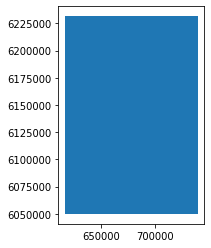

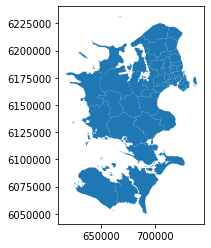

In [13]:
# [Your answer here]

# Extract extremum values
small_coor = sealand.total_bounds # [minx, miny, maxx, maxy]
smallest_square = Polygon(np.array([[small_coor[0],small_coor[1]], [small_coor[2],small_coor[1]], 
                                    [small_coor[2], small_coor[3]], [small_coor[0], small_coor[3]]])) 

smallest_square = gpd.GeoSeries(smallest_square)
smallest_square.plot()
sealand.plot()

<br>

### Interpolation of house prices


In the following two exercises we aim to compute local spatial neighborhood measures of house prices in Sealand and around. We do this by making make a grid of Sealand houseprice data and using a neighborregressor to fill in data in squares that dont have any house sales. Thus the exercise will illustrate how to make a interpolation of data which is useful for feature engineering and get a good understanding of the data.

> **Ex. 7.2.4** Construct a 500mx500m grid for Sealand:
>- Make a grid of points 500m apart in horizontal and vertical directions that are within the extremum values of Sealand's shape. Each pair $(e,n)$ in this grid should be the coordinates of the lower left corner in a 500x500 square.
>- For each of these points construct a square polygon assuming that the point is the south west corner of the square. Do this using `cell_coords_to_polygons`.
>- Use `gpd.sjoin` to take the intersection of the municipalities in sealand and the square grid you have constructed. Plot the resulting geodataframe.
>
> *Hint 1:* Once you have created the grid the following function below may be useful for converting into a GeoDataFrame. You need to specify the column names for your x and y coordinates.
>
> *Hint 2:* We can select the points that intersect by using a spatial join between the house locations and municipalities.

**Note**:

Sorry I didn't use the function `cell_coords_to_polygons`, but I couldn't figure out what the `square_df` input should be.

In [14]:
dk_crs = {'ellps': 'GRS80', 'no_defs': True, 'proj': 'utm', 'units': 'm', 'zone': 32}

def cell_coords_to_polygons(square_df, x='e', y='n', dist=500, crs=dk_crs):
    '''
    Convert coordinates to squares in a GeoDataFrame.
       
    Parameters
    ----------
    x : str
        Name of the horizontal coordinate (~longitude)            
    y : str
        Name of the vertical coordinate (~latitude)                        
    dist : int or float
        Size of polygons
    crs : dict
        Coordinate Reference System


    Returns
    ----------
    squares_gdf: geopandas.GeoDataFrame
        This table contains squares as geometry
        and the original data.
    '''
    
    def _to_square_polygon(row):
        '''
        This auxiliary function convert a square's lower,left 
        coordinates to a polygon. 
        
        Parameters
        ----------
        row : pandas.Series
            This is a DataFrame row.            
        
        Returns
        ----------
        poly: shapely.Polygon        
        
        '''
        
        square_coords = ((row[x], row[y]), 
                         (row[x]+dist, row[y]), 
                         (row[x]+dist, row[y]+dist), 
                         (row[x], row[y]+dist))
        
        poly = shapely.geometry.Polygon(square_coords)
        
        return poly
    
    # convert to polygons
    square_geoms = gpd.GeoSeries(square_df.apply(_to_square_polygon, axis=1), crs=crs)
    
    # make GeoDataFrame
    square_gdf = gpd.GeoDataFrame(data=square_df, geometry=square_geoms)
    
    return square_gdf

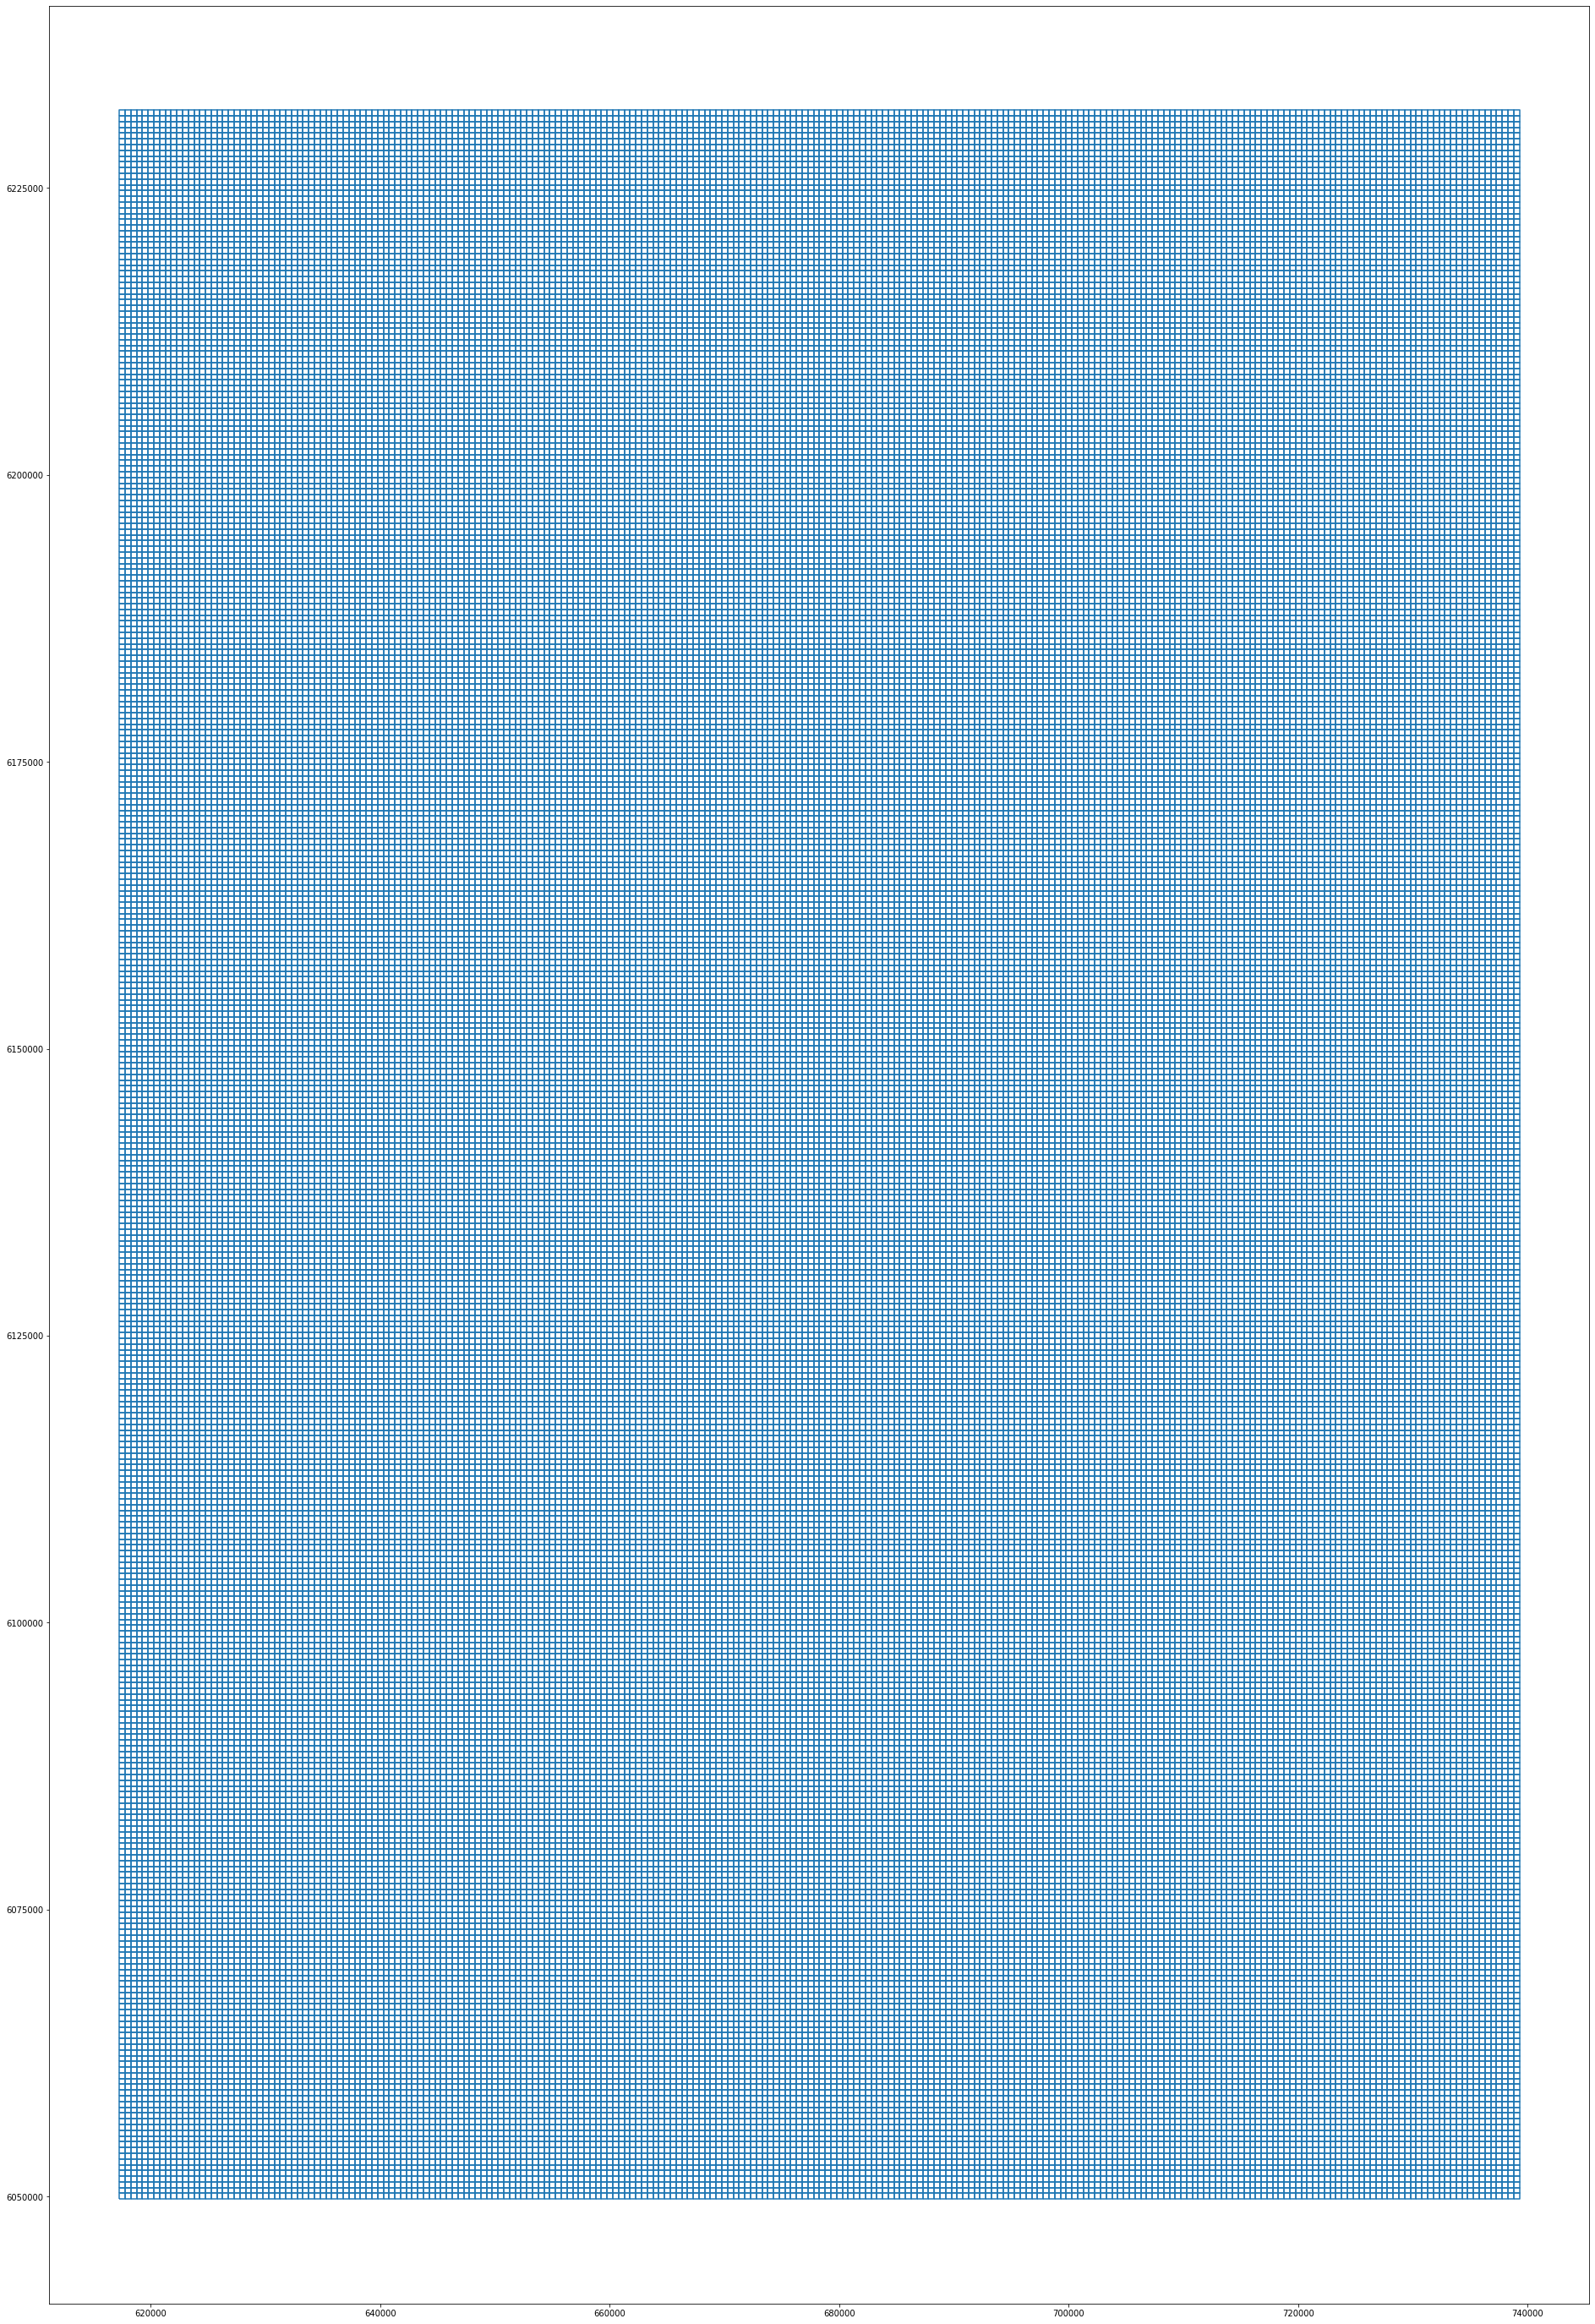

In [15]:
# [Your answer here]

# Get extremums
xmin,ymin,xmax,ymax = sealand.total_bounds

# Specify height and width of the squares
length = 500
width = 500

# Make vertical and horisontal coordinates
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))

polygons = []
coordinates = []
for x in cols:
    for y in rows:
        coordinates.append([x, y])
        polygons.append( Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]) )

grid = gpd.GeoDataFrame(data=coordinates, geometry=polygons, crs={'init': 'epsg:25832'})

# Rename column to 'e' and 'n'
columns_dict = {}
columns_dict[0] = 'e'
columns_dict[1] ='n'

grid.rename(columns=columns_dict, inplace=True)

# Show grid
grid.boundary.plot(figsize=(50,50))

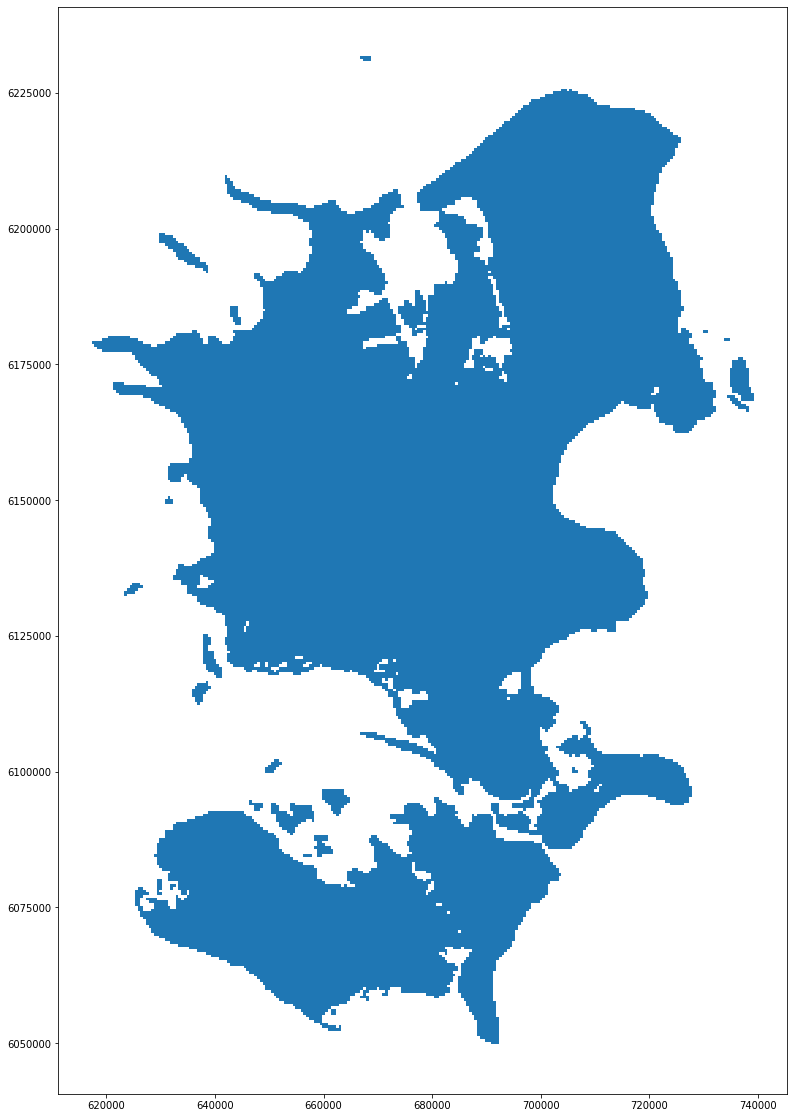

In [17]:
# Intersection of grid and mainland Sealand
intersection = gpd.sjoin(grid, sealand)
intersection.plot(figsize=(20,20))

> **Ex. 7.2.5**  Load the pre-structured data with house sales prices for Sealand. These data are available on Absalon as a .GeoJSON file. Construct a loop that for each year in the `sale_year` column 
> - Extracts the house sales sold in this year, with a square meter price (`price_area`) between between 1000 and 120000. 
> - Selects the four columns `['sale_year', 'e', 'n', 'price_area']` and drops any rows with missing data. 
> - After preparing the data fit a `KNeighborsRegressor` with the coordinate columns `e` and `n` as features and the square-meter price as labels.
> - Computes predictions `preds` where `e`, `n` are taken from the square grid geodataframe you constructed above. Add 250 to each value to predict at the midpoint of the square!
> - Creates a new column `p_{year}` in the square-grid geodataframe, containing `np.log10(preds)`
>
> Plot the grid data, coloring the grids by their predicted square meter price in 2012.

In [18]:
from sklearn.neighbors import KNeighborsRegressor
price_gdf = gpd.read_file('houseprices.GeoJSON')

In [19]:
price_gdf.head(1)

,address,buildYear,salesPeriodTotal,numberOfRooms,paymentCash,residentialArea,areaWeighted,postal,dateRemoved,city,lat,lon,price_area,price_area_log,sale_year,e,n,index_right,mun_name,geometry
0,"Topperne 11, 1. 12",1972,NaN,2,645000.0,49.0,49.0,2620,19-01-2012,Albertslund,55.672423,12.343027,13163.265306,9.485185,2012,710214.000597,6.174689e+06,250,Albertslund,POINT (710214.001 6174689.003)


In [20]:
# [Your answer here]

for y in pd.unique(price_gdf['sale_year']):
    
    # Delete missing rows
    price_gdf.dropna(subset=['sale_year', 'e', 'n', 'price_area'], inplace=True)
    
    # Extract house sales in sqm price interval [1000:120000]
    I = (price_gdf['price_area'] >= 1000) & (price_gdf['price_area'] <= 120000) & (price_gdf['sale_year'] == y)
    new_df = price_gdf.loc[I==True, :]
    
    # Define model and data
    model = KNeighborsRegressor()
    X = new_df.loc[:,['e', 'n']]
    y_train = new_df['price_area']
    X_test = grid.loc[:,['e', 'n']]
    X_test['e'] += 250
    X_test['n'] += 250
    
    # Fit and predict
    model.fit(X, y_train)
    preds = model.predict(X_test)
    
    # Make column
    p = []
    for row in preds:
        p.append(np.log10(row))
    grid['p_' + str(y)] = p

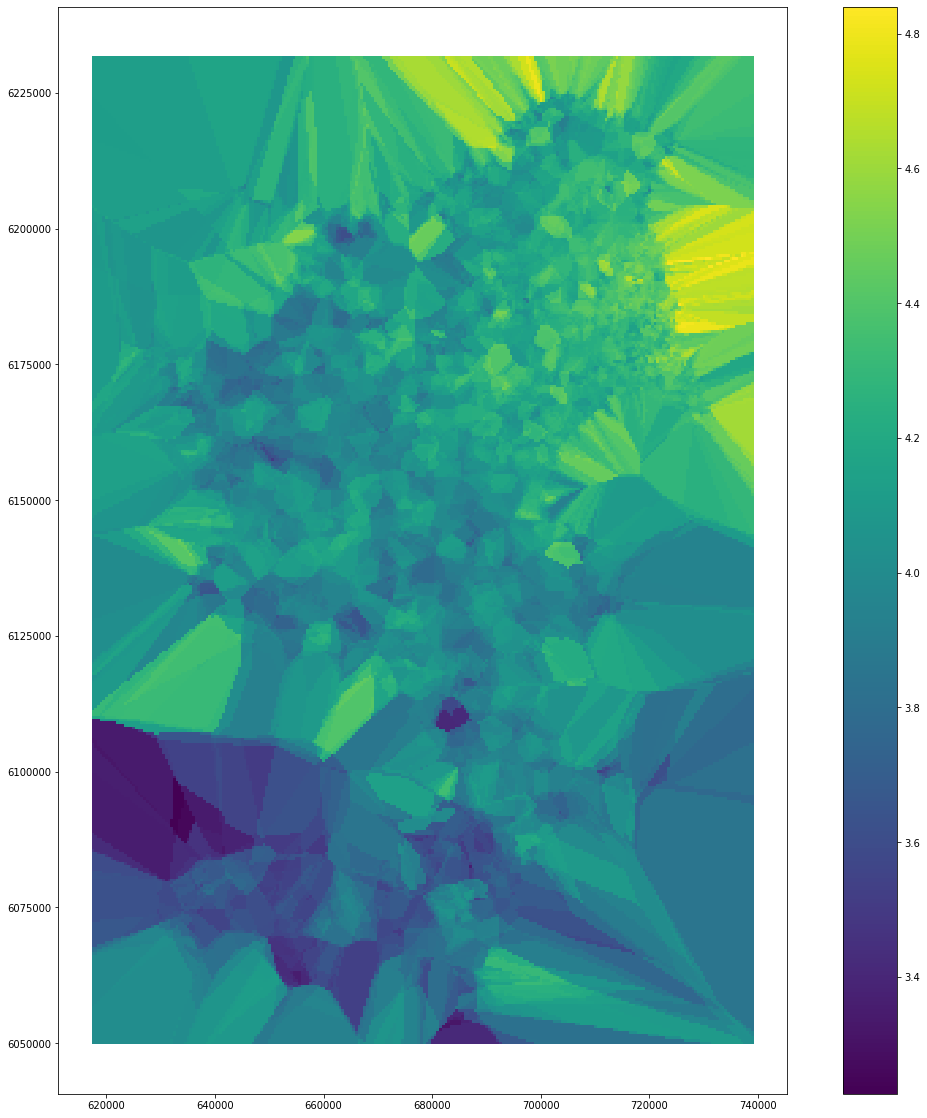

In [21]:
grid.plot(figsize=(20,20), column='p_2012', legend=True)